Import libraries

In [ ]:
! pip install datasets
! pip install diffusers[training]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from tqdm.auto import tqdm
import time
import math

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize, Compose

from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup

from accelerate import Accelerator
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Import and preprocess dataset

In [ ]:
#get dataset
dataset = load_dataset("nelorth/oxford-flowers", split="test")
print(len(dataset))

dataset = dataset.select(range(100))
print(len(dataset))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/7169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1020 [00:00<?, ? examples/s]

1020
100


torch.Size([3, 128, 128])


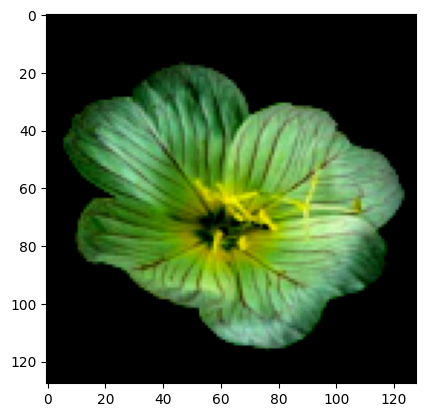

In [ ]:
def transform(examples):
    preprocess = Compose(
        [
        Resize((128, 128)),
        ToTensor(),
        Normalize([0.5], [0.5]),
      ]
    )
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

def show_image(img):
    np_img = img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow(np_img)
    plt.show()

#preprocess dataset
dataset.set_transform(transform)
sample = dataset[0]["images"]
print(sample.shape)

show_image(sample)

Set noise scheduler, dataloader, and UNet model

noisy image size: torch.Size([3, 128, 128])


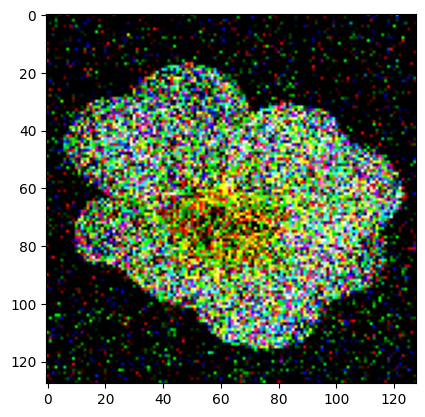

In [ ]:
#add noise to image
def add_noise(img, noise_factor=0.7):
    noisy_img = img + noise_factor * torch.randn(img.size())
    noisy_img = torch.clamp(noisy_img, 0., 1.)
    return noisy_img

noisy_img = add_noise(sample)
print('noisy image size:',sample.size())
show_image(noisy_img)

torch.Size([3, 128, 128])
torch.Size([16, 3, 128, 128])


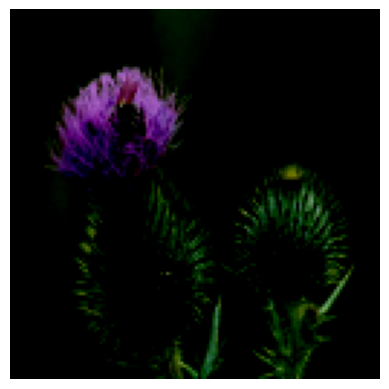

In [ ]:
batch_size = 16

#create dataloader
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

#show a picture from dataloader
for step, batch in enumerate(train_dataloader):
    img = batch['images']
    print(img[0].shape)
    print(img.shape)
    plt.imshow(img[0].permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()
    break

In [ ]:
#DDPM model
model = UNet2DModel(
    sample_size=128,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [ ]:
#hyperparameters
num_epochs = 30
learning_rate = 1e-3
num_train_timesteps = 500

In [ ]:
#check if input and output shape of ddpm model is same
sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


Without DIP

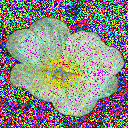

In [ ]:
#create noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps,beta_schedule="linear")
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])
#print(noisy_image.device)

In [ ]:
noise_pred = model(noisy_image, timesteps).sample # tensor
loss = F.mse_loss(noise_pred, noise)

#function to show_tensor
def show_tensor(img):
  # # Remove the batch dimension (assuming batch size is 1)
  image = img.squeeze(0)
  # # Convert the tensor to a PIL image
  to_pil = transforms.ToPILImage()
  image = to_pil(image)
  display(image)

In [ ]:
#setup optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [ ]:
#function to show DDPM result
def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid

In [ ]:
#train DDPM using accelerator
def train_loop(model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):

    accelerator = Accelerator(
        mixed_precision="fp16" ,
        gradient_accumulation_steps=1,
        log_with="tensorboard",
        project_dir=os.path.join("ddpm-flowers", "logs"),
    )
    if accelerator.is_main_process:
        os.makedirs("ddpm-flowers", exist_ok=True)
        accelerator.init_trackers("train_example")

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0
    start_time = time.time()
    for epoch in range(30):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]

            noise =  torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):

                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1
    end_time = time.time()
    total_time = end_time - start_time
    print("total time (s): ",round(total_time))
    print("total step: ",global_step)

In [ ]:
args = (model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
train_loop(model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

total time (s):  154
total step:  210


  0%|          | 0/500 [00:00<?, ?it/s]

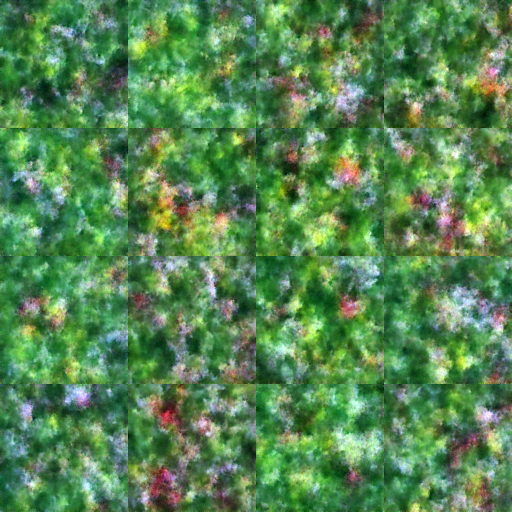

In [ ]:
accelerator = Accelerator(
        mixed_precision="fp16",
        gradient_accumulation_steps=1,
        log_with="tensorboard",
        project_dir=os.path.join("ddpm-flowers", "logs"),
    )

#show result
pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
images = pipeline(
        batch_size=16,
        generator=torch.manual_seed(0),
        num_inference_steps=500,
    ).images
image_grid = make_grid(images, rows=4, cols=4)
image_grid

In [ ]:
#get psnr and ssim
def calculate_psnr(input, output):
    psnr = peak_signal_noise_ratio(input, output)
    return round(psnr,3)

def calculate_ssim(input, output):
    ssim, _ = structural_similarity(input, output, full=True, multichannel=True)
    return round(ssim,3)

total_psnr = 0
total_ssim = 0
for image in images:
  output = np.array(image)/255
  batch_psnr = 0
  batch_ssim = 0
  for i in range(16):
    input = dataset[i]['images'].squeeze(0)
    input = input.permute(1, 2, 0).numpy()
    psnr = calculate_psnr(input,output)
    ssim = calculate_ssim(input,output)
    batch_psnr += psnr
    batch_ssim += ssim
  total_psnr += batch_psnr/16
  total_ssim += batch_ssim/16
print('PSNR:',round(total_psnr/16,3))
print('SSIM:',round(total_ssim/16,3))

<ipython-input-26-b8e7051988f4>:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(original_image, reconstructed_image)
<ipython-input-26-b8e7051988f4>:8: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim, _ = structural_similarity(original_image, reconstructed_image, full=True, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


PSNR: 6.588
SSIM: -0.038


With DIP

In [ ]:
#initiate DIP class
class DIPModel(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(DIPModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
#train DIP
def train_DIP(image, num_epochs, lr):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DIPModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        for step, batch in enumerate(dataset):
            image = batch["images"].to(device)
            optimizer.zero_grad()
            output = model(torch.randn_like(image).to(device))  # Start with random noise
            loss = criterion(output, image)
            loss.backward()
            optimizer.step()


        if epoch % 50 == 0:
           print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model

In [ ]:
#train the dip model
dip_model = train_DIP(train_dataloader, 200, 0.001)

Epoch 0, Loss: 0.5166786909103394
Epoch 50, Loss: 0.5165296196937561
Epoch 100, Loss: 0.5165278315544128
Epoch 150, Loss: 0.5165278315544128


In [ ]:
model= UNet2DModel(
    sample_size=128,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps,beta_schedule="linear")
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=(len(train_dataloader) * 30),
)

In [ ]:
def train_loop(model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, dip_model):

    accelerator = Accelerator(
        mixed_precision="fp16",
        gradient_accumulation_steps=1,
        log_with="tensorboard",
        project_dir=os.path.join("ddpm-flowers", "logs"),
    )
    if accelerator.is_main_process:
        os.makedirs("ddpm-flowers", exist_ok=True)
        accelerator.init_trackers("train_example")

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0
    start_time = time.time()
    for epoch in range(30):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]

            initial_prior = dip_model(torch.randn_like(clean_images)).detach()
            noisy_images = initial_prior

            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            timesteps = torch.randint(
                0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
            ).long()
            noisy_images = noise_scheduler.add_noise(noisy_images, noise, timesteps)

            with accelerator.accumulate(model):

                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1
    end_time = time.time()
    total_time = end_time - start_time
    print("total time (s): ", round(total_time))
    print("total step: ", global_step)

train_loop(model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, dip_model=dip_model)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

total time (s):  151
total step:  210


  0%|          | 0/500 [00:00<?, ?it/s]

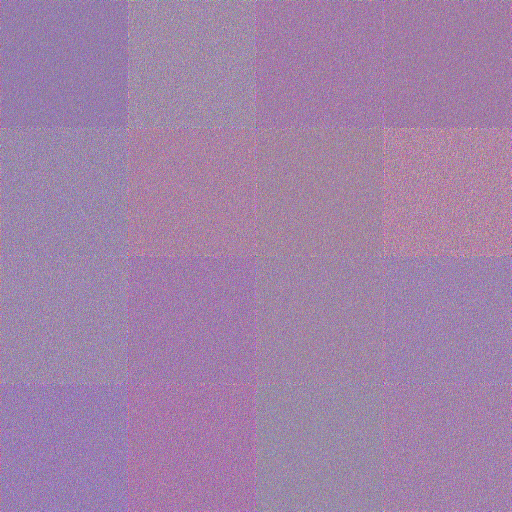

In [ ]:
accelerator = Accelerator(
        mixed_precision="fp16",
        gradient_accumulation_steps=1,
        log_with="tensorboard",
        project_dir=os.path.join("ddpm-flowers", "logs"),
    )

pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
images = pipeline(
        batch_size=16,
        generator=torch.manual_seed(0),
        num_inference_steps=500,
    ).images
image_grid = make_grid(images, rows=4, cols=4)
image_grid

In [ ]:
def calculate_psnr(input, output):
    psnr = peak_signal_noise_ratio(input, output)
    return round(psnr,3)

def calculate_ssim(input, output):
    ssim, _ = structural_similarity(input, output, full=True, multichannel=True)
    return round(ssim,3)

total_psnr = 0
total_ssim = 0
for image in images:
  output = np.array(image)/255
  batch_psnr = 0
  batch_ssim = 0
  for i in range(16):
    input = dataset[i]['images'].squeeze(0)
    input = input.permute(1, 2, 0).numpy()
    psnr = calculate_psnr(input,output)
    ssim = calculate_ssim(input,output)
    batch_psnr += psnr
    batch_ssim += ssim
  total_psnr += batch_psnr/16
  total_ssim += batch_ssim/16
print('PSNR:',round(total_psnr/16,3))
print('SSIM:',round(total_ssim/16,3))

<ipython-input-32-cd73826adae3>:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(input, output)
<ipython-input-32-cd73826adae3>:6: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim, _ = structural_similarity(input, output, full=True, multichannel=True)


PSNR: 6.442
SSIM: -0.06
